# Supervised learning/classification of Columbia River Basalt data

This script trains a logistic regression model for classifying CRB samples, focusing on major and trace lements (+/- magnetic polarity) at the formation and member levels

Authors: Rachel Hampton and Leif Karlstrom, 2024

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.metrics.cluster import v_measure_score
from scipy import stats
#from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import PowerTransformer
from importlib import reload
import math
from sklearn.utils import resample
from IPython.display import display
import pickle
import sys
import importlib

sys.path.append('../../scripts/')
# Contains special functions used in the script
import GeochemFunctions as geofctns
importlib.reload(geofctns)

!pwd

/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB


## Here is where we load data

In [8]:
############# CRB DATAFRAME UPDATED
#NOTE: the "Umtanum" member class has been dropped from this version
path = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_database2025_withmemberlabels.csv'
#CRB_dataframe_completed_2024_V2.csv'
data_=pd.read_csv(path, header=0)

features_sorted = data_.sort_values(["MemberID"], ascending=True)

#############################################
######### Here is where we decide what elements/ features to classify on
#this one uses only major elements (except iron)
# features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3','Y','V', 'Nb', 'Ga', 'Cu','Zn', 'Pb', 'La', 'Ce', 'Th', 'U','Ni', 'Cr', 'Sc', 'Ba', 'Rb', 'Sr', 'Zr', 'Source'])
# version = '_majorelementsonly'

#this one maximizes the number of samples
#features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3','Y','V', 'Nb', 'Ga', 'Cu','Zn', 'Pb', 'La', 'Ce', 'Th', 'U', 'Source'])
#this one drops features not in the Hughes dike data
features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Ga', 'La', 'Ce', 'Zn','Pb','Th', 'U'])

version = '_maximize_samples'

#this maximizes the accuracy by including more elements, still retaining Indian Ridge member from Reidel (restrictive...)
# features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Zn', 'U', 'Source'])
# version = '_maximize_elements'

features_ = features__.dropna(axis=0, how='any')

#drop the "undifferentiated" member class --- come back to this later?
features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)

#features_.to_csv('CRBdatabase_D3.csv', index=False)
print('number of unique sources = ' + str(features_['Source'].nunique()))
#############################################
######### Here is where we decide whether to classify on member vs formation 
#member level
labels= features_.loc[:,'MemberID']
label_names=features_.loc[:,'Member']

IDlabel = 'MemberID'
IDname = 'Member'

#formation level
# labels= features_.loc[:,'FormationID']
# ## 0=PGB, 1=Steens, 2=Imnaha, 3=GRB, 4=Wanapum, 5=SMB

# label_names=features_.loc[:,'Formation']
# IDlabel = 'FormationID'
# IDname = 'Formation'

df = features_
labels_df = labels
#############################################
#Build lookup table connecting IDs to names of classes
# Find unique class IDs
unique_ID = labels.unique()

NumSamplesPerClass = []
ClassName = []

for value in unique_ID:
    corresponding_class = df[df[IDlabel] == value][IDname].values
    NumSamplesPerClass.append(len(corresponding_class))
    ClassName.append(df[df[IDlabel] == value][IDname].values[0])
    
LookupTable = pd.DataFrame({'MemberID': unique_ID, 'Member': ClassName, 'NumSamples': NumSamplesPerClass})
LookupTable = LookupTable.sort_values(by='MemberID')

print(LookupTable)#["MemberID"].to_string(index=False))
#save the features used 
filename = IDname+'LookupTable' + version + '.pkl'
pickle.dump(LookupTable, open(filename, 'wb'))
print(df.columns)
#############################################

df = df.drop(columns=['Member', 'MemberID', 'FormationID', 'Formation', 'Polarity','Reference','Source'])

filename = 'TrainingDataFeatures' + version + '.pkl'
pickle.dump(df.columns.values, open(filename, 'wb'))

#print(df.columns.values)

#make ratios between every feature and every other feature  
df = pd.DataFrame(geofctns.makeratios(df))

#power transform to normalize values
df = geofctns.normalizedata(df,'powert')

print(np.shape(df))


/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_16383/2098247931.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)


number of unique sources = 43
    MemberID            Member  NumSamples
0          0       LowerSteens          78
1          1       UpperSteens          32
2          2          LogCreek          20
3          3         FallCreek           8
4          4       AmericanBar          99
5          5         RockCreek          68
6          6      PictureGorge         138
7          7   BuckhornSprings          20
8          8        BirchCreek          38
9          9       TeepeeButte          31
10        10        Rogersburg          23
11        11     SkeletonCreek          38
12        12       CenterCreek          10
13        13      KendrikGrade          27
14        14        BradyGulch          21
15        15       DowneyGulch          59
16        16         FryePoint          17
17        17        ChinaCreek          40
18        18       HoskinGulch          56
19        19  ColdSpringsRidge          74
20        20     MountHorrible          38
21        21    Wapshill

In [64]:
#################################
#if needed, divide up into stratigraphic labels of interest 

df_gr= features_.loc[(features_['FormationID'] == 3)]
df_st= data_.loc[(data_['FormationID'] == 1)]
df_sm= data_.loc[(data_['FormationID'] == 5)]
df_pg= data_.loc[(data_['FormationID'] == 0)]
df_im= data_.loc[(data_['FormationID'] == 2)]
df_wp= data_.loc[(data_['FormationID'] == 4)]
df_wap=data_.loc[(data_['MemberID'] == 20)]

df_mr=data_.loc[(data_['MemberID'] == 22)]


df_sb=data_.loc[(data_['MemberID'] == 30)]
#df_bs=data_.loc[(data_['MemberID'] == 9)]
#df_em=data_.loc[(data_['MemberID'] == 35)]
#df_tb=data_.loc[(data_['MemberID'] == 11)]
#df_rb=data.loc[(data['MemberID'] == 6)]
#df_pomona=data.loc[(data['MemberID'] == 39)]
#df_weippe=data.loc[(data['MemberID'] == 40)]
#df_mthr=data.loc[(data['MemberID'] == 17)]
df_gc=data_.loc[(data_['MemberID'] == 21)]
#df_fs=data_.loc[(data_['MemberID'] == 30)]
df_reversed_ = df_gr.loc[(data_['Polarity'] == 0)]

rv_labels= pd.DataFrame(df_reversed_.loc[:,'MemberID'])
df_reversed = df_reversed_.drop(columns=['Member','MemberID', 'FormationID', 'Polarity'])



df_gr= features_.loc[(features_['FormationID'] == 3)] #Grande Ronde
#df_gr.drop(df_gr.index[df_gr['MemberID'] == 48], inplace=True)
gr_labels= pd.DataFrame(df_gr.loc[:,'MemberID'])


#dfgr = df_gr.drop(columns=['Member','MemberID', 'FormationID'])
dfgr = df_gr.drop(columns=['Member','MemberID', 'FormationID'])

#Imnaha Data For Training
df_im= features_.loc[(features_['FormationID'] == 2)] #Grande Ronde
#df_gr.drop(df_gr.index[df_gr['MemberID'] == 48], inplace=True)
im_labels= pd.DataFrame(df_im.loc[:,'MemberID'])


#dfgr = df_gr.drop(columns=['Member','MemberID', 'FormationID'])
dfim = df_im.drop(columns=['Member','MemberID', 'FormationID'])



In [3]:
subset_columns = [ 'TiO2','Ni','Sc','Na2O','Y','Cu','K2O','Nb','V','SiO2','MgO','P2O5','MnO','CaO','Al2O3']
df[df.duplicated(subset=subset_columns, keep=False)]#.to_csv('duplicates.csv')
print(np.shape(df))
df.drop_duplicates()#subset=subset_columns)
np.shape(df)

(4600, 27)


(4600, 27)

# Train model for classification

In [51]:
############### Train model by iterating over the random state parameter

#no polarity for now
#df = df.drop(columns=['Polarity'])
    
t1 = time.time()
random_state=50
Accuracy=[]
for r in range(random_state):
    features_train, features_test, labels_train, labels_test = train_test_split(df, labels_df, test_size=.3, random_state=r, stratify = labels_df)
    lr1 = LogisticRegression(solver = 'lbfgs', max_iter=1500, multi_class='multinomial')
    lr1.fit(features_train, labels_train)

# We want to check model performance (accuracy)
    accuracy = lr1.score(features_test, labels_test)
    Accuracy.append(accuracy)    

50

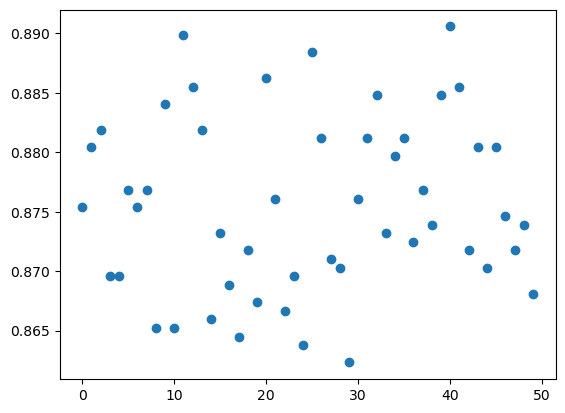

In [52]:
plt.figure()
plt.scatter(range(random_state), Accuracy)
random_state

In [55]:
accuracymax = max(Accuracy)
rspos = Accuracy.index(accuracymax)
xmax = range(random_state)[rspos]

run_time1 = time.time() - t1
print('Run Time 1=:', run_time1)

features_train_b, features_test_b, labels_train_b, labels_test_b = train_test_split(df, labels_df, test_size=0.3, random_state=xmax, stratify = labels_df)
lr_best = LogisticRegression(solver = 'lbfgs', max_iter=2500, multi_class='multinomial')
lr_best.fit(features_train_b, labels_train_b)

Run Time 1=: 776.5049819946289


LogisticRegression(max_iter=2500, multi_class='multinomial')

Precision: 0.8878558550406396
Recall: 0.8905797101449275


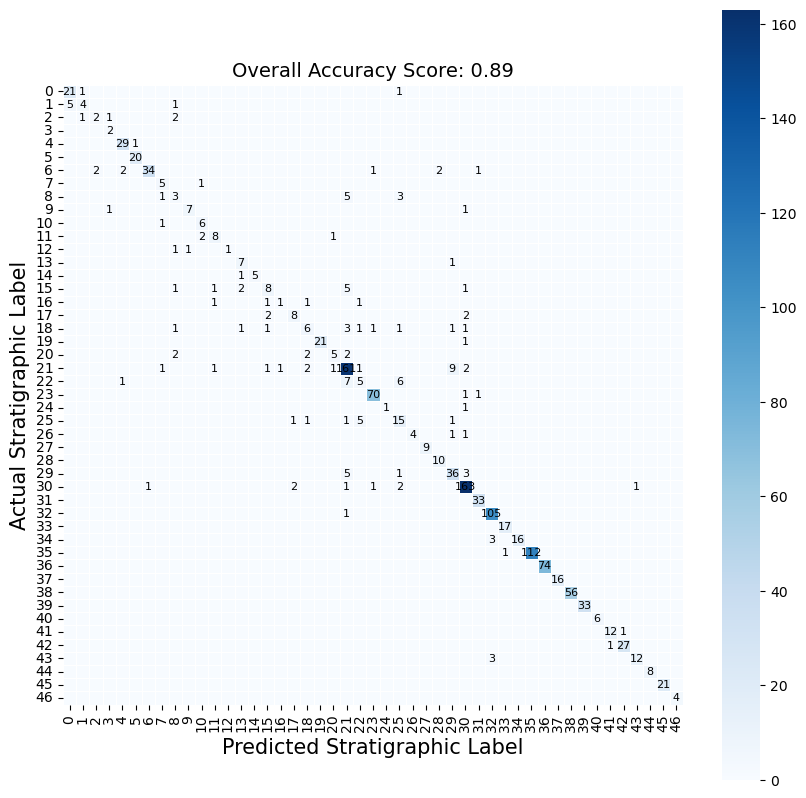

In [56]:
### Metrics for Test Data (accuracy, HCV, precision, recall)

predictions_best=lr_best.predict(features_test_b)

precision = metrics.precision_score(labels_test_b, predictions_best, average='weighted')
print('Precision:',precision)
recall = metrics.recall_score(labels_test_b, predictions_best, average='weighted')
print('Recall:',recall)
accuracy_best = lr_best.score(features_test_b, labels_test_b)


labels_test_b=pd.DataFrame(labels_test_b)
cm_labelz=labels_test_b.sort_values([IDlabel], ascending=True)
cm_labels=cm_labelz[IDlabel].unique()

### Plot Confusion Matrix
formations = ['Picture Gorge',' Steens', 'Imnaha', 'Grande Ronde', 'Wanapum', 'Saddle Mountains']
cm2 = pd.DataFrame(metrics.confusion_matrix(labels_test_b, predictions_best))
plt.figure(figsize=(10,10))
#sns.heatmap(cm2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues',  xticklabels=formations, yticklabels=formations);
sns.heatmap(cm2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=cm_labels, yticklabels=cm_labels);
#sns.heatmap(cm2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

for text in plt.gca().texts: # Adjust text properties
    if int(text.get_text()) > 0:
        text.set_color("black") 
        text.set_fontsize("8")
    else:
        text.set_text("") # Remove zero values labels


plt.ylabel('Actual Stratigraphic Label', fontsize=15);
plt.xlabel('Predicted Stratigraphic Label', fontsize=15);
all_sample_title = 'Overall Accuracy Score: {0}'.format("%.2f" % accuracy_best)
plt.title(all_sample_title, size = 14);
#plt.xticks(np.arange(6), formations)
#plt.yticks(np.arange(6), formations)
plt.savefig('MemberConfusionMatrix.pdf')

## Now generate a model that uses 100% of the data

After assessing accuracy on part of the training dataset, we want the best possible model to use for classifying unknown samples

In [57]:
#### With 100% of the data:
lr_best_100 = LogisticRegression(solver = 'lbfgs', max_iter=2500, multi_class='multinomial')
lr_best_100.fit(df, labels_df)

data_labels_100=labels_df

lr_best_100

LogisticRegression(max_iter=2500, multi_class='multinomial')

In [58]:
# save the model to disk, for fugure use
filename = 'CRB_' + IDname + '_trainedon_100pct' + version +'.pkl' 
pickle.dump(lr_best_100, open(filename, 'wb'))

datalabelname = 'CRB_' + IDname + '_labels' + version +'.pkl' 
pickle.dump(data_labels_100, open(datalabelname, 'wb'))
print(filename,datalabelname)

CRB_Member_trainedon_100pct_maximize_samples.pkl CRB_Member_labels_maximize_samples.pkl
